In [1]:
!nvidia-smi

Thu Nov 26 10:03:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import psutil
import humanize
import os
from IPython.display import display_html
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
print(os.listdir())
dataDirectory= "/content/drive/MyDrive/dataset_resized" 
print(os.listdir(dataDirectory))

['.config', 'drive', 'sample_data']
['testing', 'training', 'models', 'SAVED_MODELS']


In [3]:
!rm -r ~/.keras
!mkdir ~/.keras
!mkdir ~/.keras/models
# not enough space for both
#!cp ../input/keras-pretrained-models/* ~/.keras/models/ 
#!cp ../input/vgg19/* ~/.keras/models
!cp ../input/keras-pretrained-models/*notop* ~/.keras/models/
!cp ../input/keras-pretrained-models/imagenet_class_index.json ~/.keras/models/
#!cp ../input/keras-pretrained-models/resnet50* ~/.keras/models/

cp: cannot stat '../input/keras-pretrained-models/*notop*': No such file or directory
cp: cannot stat '../input/keras-pretrained-models/imagenet_class_index.json': No such file or directory


In [4]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.models import Model
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout
from keras.layers.convolutional import *
from keras.callbacks import ModelCheckpoint
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import decode_predictions
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from keras.preprocessing.image import load_img,img_to_array
from keras.models import model_from_json
import itertools
import matplotlib.pyplot as plt
import time
import pandas as pd
%matplotlib inline
import skimage.io
import os 
import glob
import tqdm
import tensorflow

In [70]:
train_path = dataDirectory+'/training'
test_path  = dataDirectory+'/testing'
print(os.listdir(train_path))
print(os.listdir(test_path))

['ewaste', 'cardboard', 'glass', 'paper', 'metal', 'trash', 'plastic']
['trash', 'metal', 'plastic', 'ewaste', 'cardboard', 'glass', 'paper']


In [71]:
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode='nearest',
        validation_split=0.2) # set validation split

In [72]:
selectedClasses = [ 'cardboard','ewaste', 'glass', 'metal','paper', 'plastic', 'trash'] 

In [118]:
batchSize=64

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224,224),
    batch_size=batchSize,
    classes=selectedClasses,
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_path, # same directory as training data
    target_size=(224,224),
    batch_size=batchSize,
    classes=selectedClasses,
    subset='validation') # set as validation data

test_generator = ImageDataGenerator().flow_from_directory(
    test_path, 
    target_size=(224,224), 
    classes=selectedClasses,
    shuffle= False,
    batch_size = batchSize)# set as test data

Found 1933 images belonging to 7 classes.
Found 481 images belonging to 7 classes.
Found 608 images belonging to 7 classes.


In [119]:
print ("In train_generator ")
for cls in range(len (train_generator.class_indices)):
    print(selectedClasses[cls],":\t",list(train_generator.classes).count(cls))
print ("") 

print ("In validation_generator ")
for cls in range(len (validation_generator.class_indices)):
    print(selectedClasses[cls],":\t",list(validation_generator.classes).count(cls))
print ("") 

print ("In test_generator ")
for cls in range(len (test_generator.class_indices)):
    print(selectedClasses[cls],":\t",list(test_generator.classes).count(cls))

In train_generator 
cardboard :	 258
ewaste :	 316
glass :	 320
metal :	 263
paper :	 380
plastic :	 308
trash :	 88

In validation_generator 
cardboard :	 64
ewaste :	 79
glass :	 80
metal :	 65
paper :	 95
plastic :	 77
trash :	 21

In test_generator 
cardboard :	 81
ewaste :	 100
glass :	 101
metal :	 82
paper :	 119
plastic :	 97
trash :	 28


In [120]:
#plots images with labels within jupyter notebook
def plots(ims, figsize = (22,22), rows=4, interp=False, titles=None, maxNum = 9):
    if type(ims[0] is np.ndarray):
        ims = np.array(ims).astype(np.uint8)
        if(ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
           
    f = plt.figure(figsize=figsize)
    #cols = len(ims) //rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    cols = maxNum // rows if maxNum % 2 == 0 else maxNum//rows + 1
    #for i in range(len(ims)):
    for i in range(maxNum):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=20)
        plt.imshow(ims[i], interpolation = None if interp else 'none')   

In [121]:
train_generator.reset()
imgs, labels = train_generator.next()

#print(labels)

labelNames=[]
labelIndices=[np.where(r==1)[0][0] for r in labels]
#print(labelIndices)

for ind in labelIndices:
    for labelName,labelIndex in train_generator.class_indices.items():
        if labelIndex == ind:
            #print (labelName)
            labelNames.append(labelName)

#labels

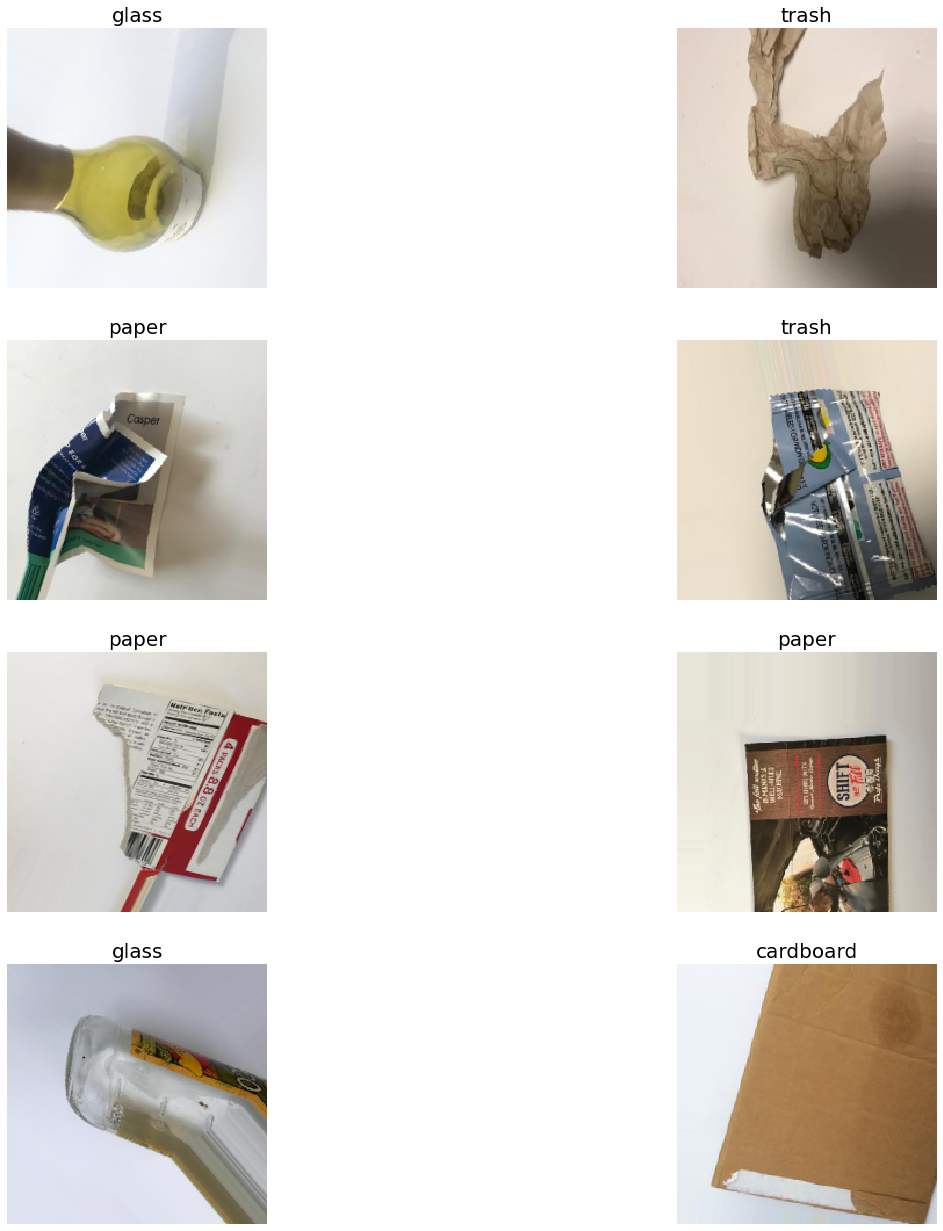

In [12]:
plots(imgs, rows=4, titles = labelNames, maxNum=8)

In [122]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

In [123]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

In [124]:
test_generator

In [125]:
callbacks = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')
filepath='./best_weights.hdf5'
best_model = ModelCheckpoint( filepath,monitor='val_acc', verbose = 1, save_best_only = True)
#reduce_lr = ReduceLROnPlateau(patience=5, monitor='val_acc', factor=0.1, min_lr=0.0000001, mode='auto', verbose=1)

In [126]:
img_width=224; img_height=224
batch_size=64

In [127]:
vgg16_base = VGG16(include_top=False, 
                   input_tensor=None, input_shape=(img_height, img_width, 3))

In [128]:
print('Adding new layers...')
output = vgg16_base.get_layer(index = -1).output  
output = Flatten()(output)
# let's add a fully-connected layer
output = Dense(1024,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.2)(output)
output = Dense(1024,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.2)(output)
output = Dense(7, activation='softmax')(output)
print('New layers added!')

Adding new layers...
New layers added!


In [129]:
vgg16_model = Model(vgg16_base.input, output)
for layer in vgg16_model.layers[:-7]:
    layer.trainable = False
vgg16_model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [130]:
vgg16_model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics =['accuracy'])

In [131]:
# We can evaluate the model right now to see how it does before training it on our new images
initial_epochs = 3
validation_steps=32

loss0,accuracy0 = vgg16_model.evaluate(train_generator, steps = validation_steps)

31/32 [============================>.] - 30s 970ms/step - loss: 13.3226 - accuracy: 0.1097


In [132]:
import numpy as np
from datetime import datetime
import time
#from sklearn import tree
#from sklearn.preprocessing import normalize, scale
from sklearn.metrics import accuracy_score
fmt = '%H:%M:%S'
def get_current_time():
    time.ctime()
    return time.strftime(fmt)
first = get_current_time()

In [133]:
history = vgg16_model.fit_generator(train_generator,
                              epochs=30,
                              verbose=1,
                              validation_data=validation_generator,
                              callbacks = [callbacks, best_model]
                              )

Epoch 1/30
31/31 [==============================] - 40s 1s/step - loss: 1.3270 - accuracy: 0.6342 - val_loss: 3.5164 - val_accuracy: 0.5426
Epoch 2/30
31/31 [==============================] - 39s 1s/step - loss: 0.7207 - accuracy: 0.7662 - val_loss: 1.8630 - val_accuracy: 0.6486
Epoch 3/30
31/31 [==============================] - 39s 1s/step - loss: 0.5020 - accuracy: 0.8277 - val_loss: 1.3584 - val_accuracy: 0.7214
Epoch 4/30
31/31 [==============================] - 39s 1s/step - loss: 0.4144 - accuracy: 0.8634 - val_loss: 1.1643 - val_accuracy: 0.7006
Epoch 5/30
31/31 [==============================] - 38s 1s/step - loss: 0.3864 - accuracy: 0.8758 - val_loss: 1.0412 - val_accuracy: 0.7297
Epoch 6/30
31/31 [==============================] - 39s 1s/step - loss: 0.3665 - accuracy: 0.8820 - val_loss: 0.9960 - val_accuracy: 0.7464
Epoch 7/30
31/31 [==============================] - 38s 1s/step - loss: 0.3199 - accuracy: 0.8919 - val_loss: 0.9154 - val_accuracy: 0.7568
Epoch 8/30
31/31 [==

In [134]:
second = get_current_time()
print("Time taken to train(sec):", datetime.strptime(second, fmt) - datetime.strptime(first, fmt))

Time taken to train(sec): 0:09:42


In [135]:
vgg16_model.evaluate(test_generator)

10/10 [==============================] - 5s 498ms/step - loss: 0.5476 - accuracy: 0.8602


[0.5476295351982117, 0.8601973652839661]

In [137]:
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras import layers, models, Model, optimizers
from tensorflow.keras.models import load_model

In [138]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [140]:
from tensorflow.keras.models import load_model
vgg16_model.save('/content/drive/MyDrive/model_Vgg16(batch=64).h5')

In [141]:
model=models.load_model("/content/drive/MyDrive/model_Vgg16(batch=64).h5")

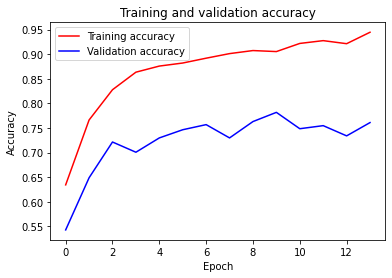

<Figure size 432x288 with 0 Axes>

In [142]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

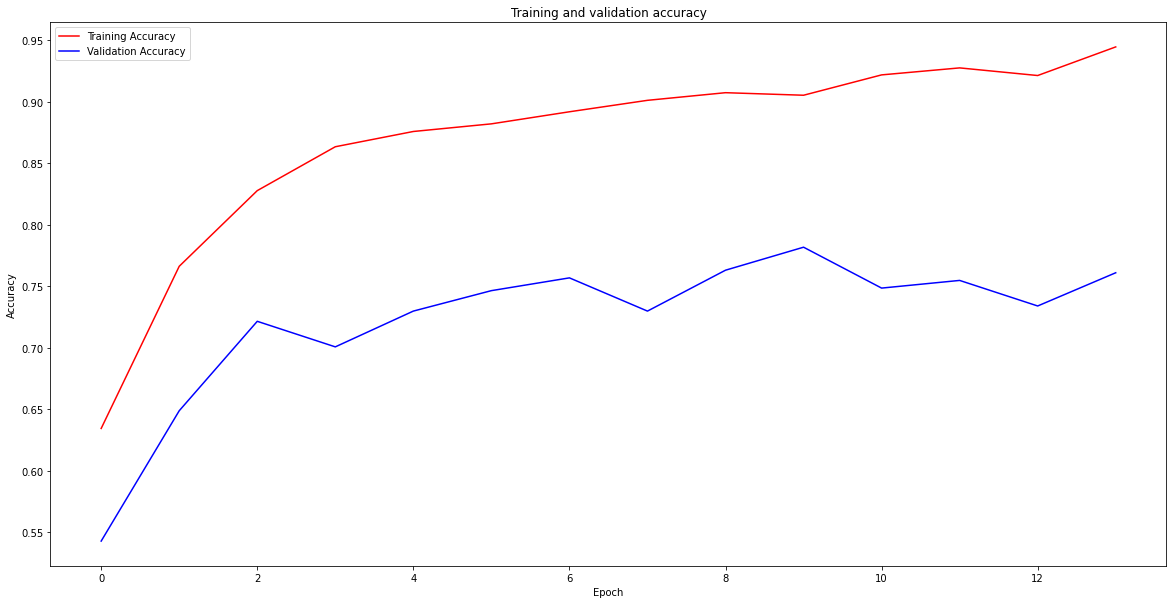

In [143]:
fig = plt.figure(figsize=(20,10))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.show()


Text(0.5, 1.0, 'Training and validation loss')

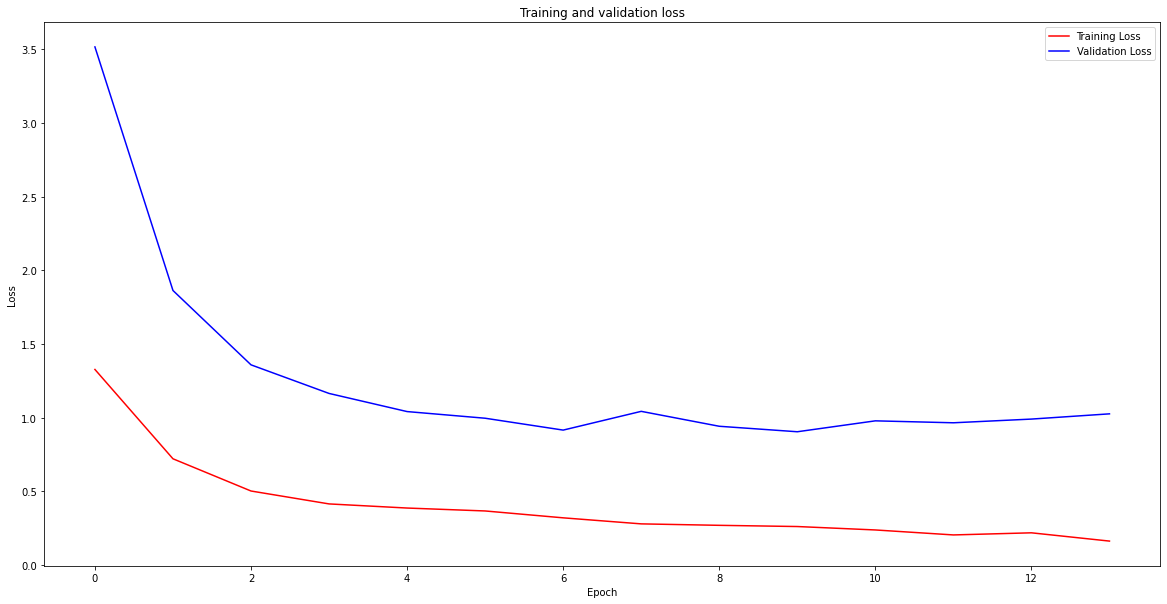

In [144]:
fig2 = plt.figure(figsize=(20,10))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [145]:
from tensorflow.python.keras.applications import vgg16
from tensorflow.python.keras.applications.vgg16 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras import layers, models, Model, optimizers

In [146]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [147]:
import itertools
def plot_confusion_matrix(cm, classes, figname,normalize=False,title='Confusion matrix',cmap=plt.cm.YlOrBr):
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
    plt.figure(figsize=(8,10))

    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                color='white' if cm[i, j] > thresh else 'black')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(figname)


Confusion matrix, without normalization


<Figure size 576x720 with 0 Axes>

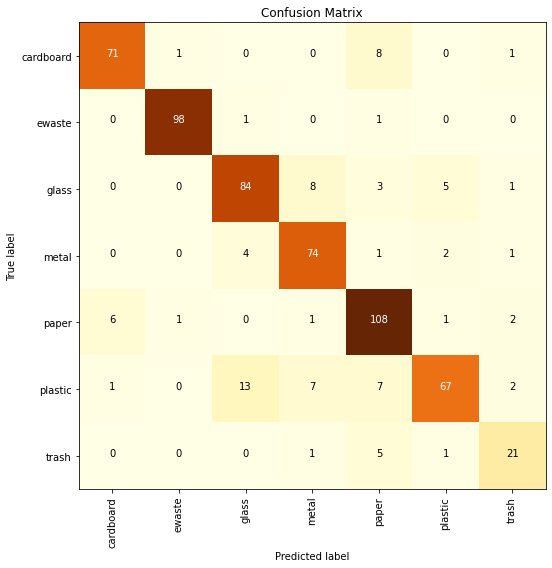

In [148]:
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, classes = selectedClasses, title='Confusion Matrix', normalize=False, figname = 'Confusion_matrix_concrete.jpg')

In [149]:
accuracy = accuracy_score(test_generator.classes, y_pred)
print("Accuracy in test set: %0.1f%% " % (accuracy * 100))

Accuracy in test set: 86.0% 


In [150]:
y_pred = model.predict(test_generator)

In [151]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 0, 0, 0, 4, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 5, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 3,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 3, 2, 4, 3, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 4, 2, 2,
       2, 2, 2, 2, 2, 6, 2, 4, 2, 2, 2, 2, 3, 2, 5, 3, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 5, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 2, 3, 3, 5, 2, 3, 3, 3, 3, 3,

In [152]:
test_generator.class_indices

{'cardboard': 0,
 'ewaste': 1,
 'glass': 2,
 'metal': 3,
 'paper': 4,
 'plastic': 5,
 'trash': 6}

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(224.224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images,batch_size=64)
  classes = np.argmax(classes, axis=1)
  print(fn)
  print(classes)

In [155]:
target_names = []
for key in test_generator.class_indices:
    target_names.append(key)

print(target_names)

['cardboard', 'ewaste', 'glass', 'metal', 'paper', 'plastic', 'trash']


Confusion Matrix
Confusion matrix, without normalization
Classification Report
              precision    recall  f1-score   support

   cardboard       0.91      0.88      0.89        81
      ewaste       0.98      0.98      0.98       100
       glass       0.82      0.83      0.83       101
       metal       0.81      0.90      0.86        82
       paper       0.81      0.91      0.86       119
     plastic       0.88      0.69      0.77        97
       trash       0.75      0.75      0.75        28

    accuracy                           0.86       608
   macro avg       0.85      0.85      0.85       608
weighted avg       0.86      0.86      0.86       608



<Figure size 576x720 with 0 Axes>

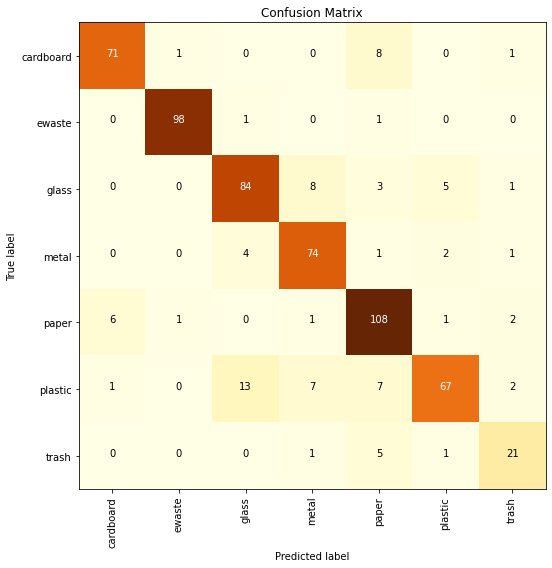

In [156]:
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix',figname = 'Confusion_matrix.jpg')

#Print Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))